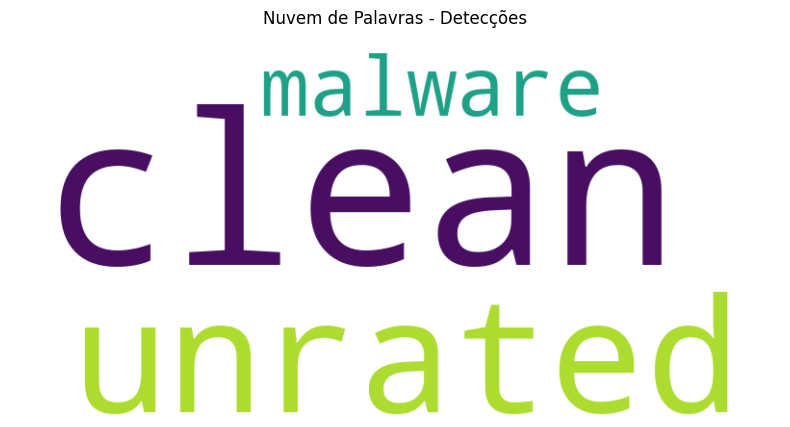

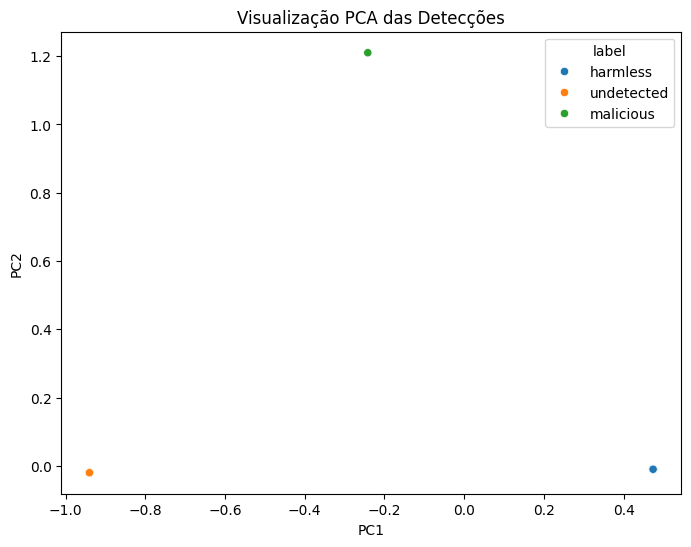

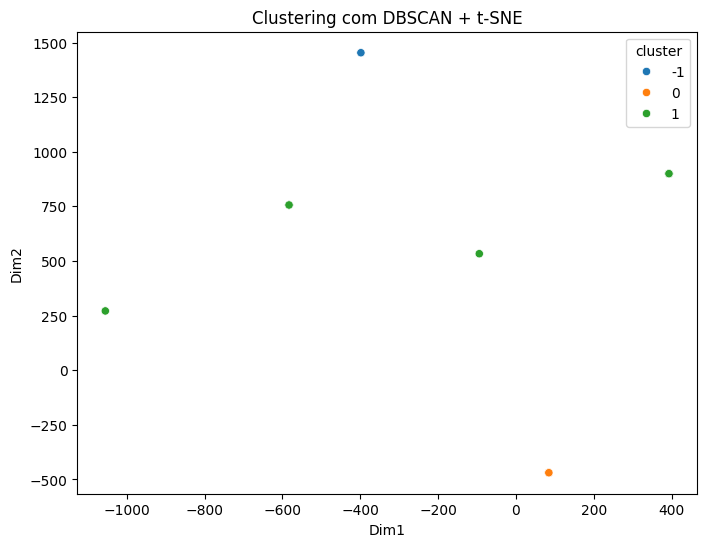

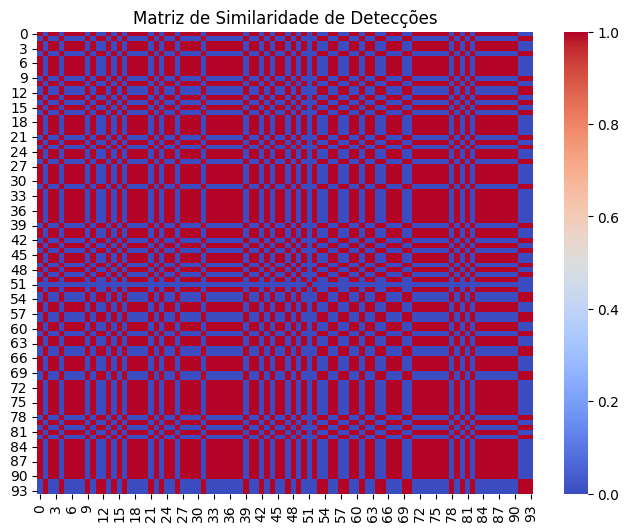

d:\projeto-pln\venv\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


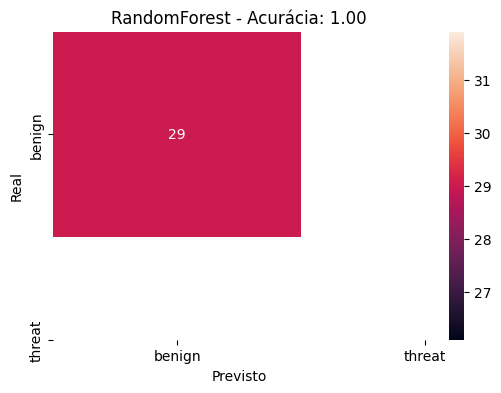

d:\projeto-pln\venv\Lib\site-packages\sklearn\decomposition\_nmf.py:133: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(res * 2)


Tópico 1: clean, unrated, malware
Tópico 2: unrated, malware, clean
Tópico 3: malware, unrated, clean


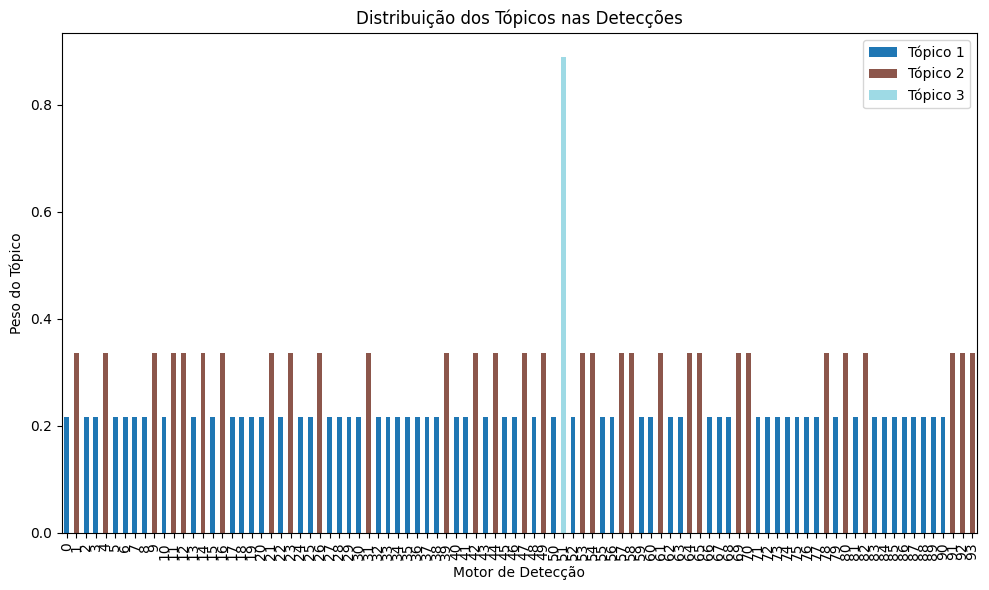

In [2]:
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix

# === 1. Carregamento do arquivo JSON ===
with open("./assets/report.txt", "r", encoding="utf-8") as f:
    data = json.load(f)

results = data['full']['attributes']['last_analysis_results']

# === 2. Extração dos textos dos motores ===
texts = []
labels = []

for engine, info in results.items():
    result_text = info.get('result')
    category = info.get('category')
    if result_text:
        texts.append(result_text)
        labels.append(category)

# === 3. Pré-processamento ===
def preprocess(text):
    text = re.sub(r"[^a-zA-Z\s]", '', text)
    return text.lower().strip()

processed = [preprocess(t) for t in texts]

# === 4. WordCloud ===
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(processed))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nuvem de Palavras - Detecções")
plt.show()

# === 5. TF-IDF ===
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(processed)

# === 6. PCA ===
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["label"] = labels

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="label")
plt.title("Visualização PCA das Detecções")
plt.show()

# === 7. Clustering com DBSCAN ===
cluster_model = DBSCAN(eps=0.6, min_samples=2)
clusters = cluster_model.fit_predict(X.toarray())

tsne = TSNE(n_components=2, perplexity=5, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())
tsne_df = pd.DataFrame(X_tsne, columns=["Dim1", "Dim2"])
tsne_df["cluster"] = clusters

plt.figure(figsize=(8, 6))
sns.scatterplot(data=tsne_df, x="Dim1", y="Dim2", hue="cluster", palette="tab10")
plt.title("Clustering com DBSCAN + t-SNE")
plt.show()

# === 8. Matriz de Similaridade ===
sim_matrix = cosine_similarity(X)
plt.figure(figsize=(8, 6))
sns.heatmap(sim_matrix, cmap="coolwarm")
plt.title("Matriz de Similaridade de Detecções")
plt.show()

# === 9. Classificação (benigno vs malicioso/suspeito) ===
y_bin = ['threat' if l in ['malicious', 'suspicious'] else 'benign' for l in labels]
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title(f"RandomForest - Acurácia: {acc:.2f}")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

# === 10. Descoberta de Tópicos com NMF ===
n_topics = 3
nmf = NMF(n_components=n_topics, random_state=42)
W = nmf.fit_transform(X)
H = nmf.components_

feature_names = vectorizer.get_feature_names_out()
for i, topic in enumerate(H):
    top_words = [feature_names[j] for j in topic.argsort()[:-6:-1]]
    print(f"Tópico {i+1}: {', '.join(top_words)}")

topic_df = pd.DataFrame(W, columns=[f'Tópico {i+1}' for i in range(n_topics)])
topic_df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')
plt.title("Distribuição dos Tópicos nas Detecções")
plt.xlabel("Motor de Detecção")
plt.ylabel("Peso do Tópico")
plt.tight_layout()
plt.show()